In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage_dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1]


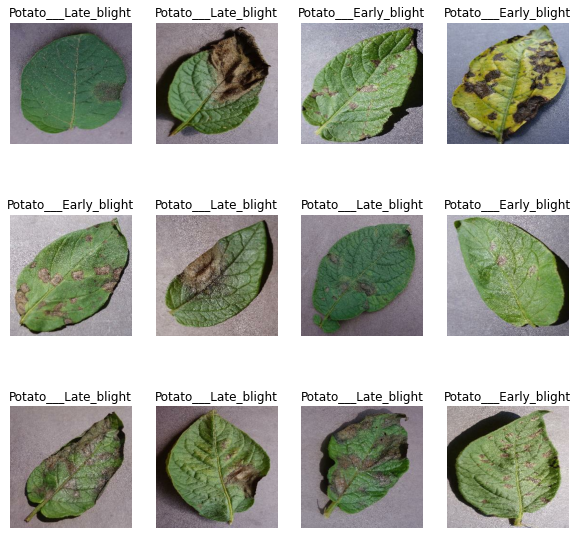

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

# Data Preprocessing

### 80% ==> training , 20% ==> 10% validation and 10% test 

In [10]:
train_size = 0.8
len(dataset)*train_size



54.400000000000006

In [11]:
train_ds= dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size 

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split=0.1, test_split=0.1,shuffle= True, shuffle_size= 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds= get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Data Resize, Rescale and data augmentation 

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# CNN

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 140s 3s/step - loss: 0.8913 - accuracy: 0.5231 - val_loss: 0.8553 - val_accuracy: 0.6615
Epoch 2/50
54/54 [==============================] - 121s 2s/step - loss: 0.7214 - accuracy: 0.6823 - val_loss: 0.6173 - val_accuracy: 0.6927
Epoch 3/50
54/54 [==============================] - 122s 2s/step - loss: 0.4325 - accuracy: 0.8293 - val_loss: 0.3246 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 123s 2s/step - loss: 0.3567 - accuracy: 0.8634 - val_loss: 0.3151 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 123s 2s/step - loss: 0.3249 - accuracy: 0.8733 - val_loss: 0.2598 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 123s 2s/step - loss: 0.2683 - accuracy: 0.8976 - val_loss: 0.2162 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 122s 2s/step - loss: 0.2821 - accuracy: 0.8883 - val_loss: 0.2070 - val_accuracy: 0.9271
Epoch 8/50
54

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 639ms/step - loss: 0.0162 - accuracy: 0.9961


In [29]:
scores

[0.01620321162045002, 0.99609375]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.5231481194496155,
 0.6822916865348816,
 0.8292824029922485,
 0.8634259104728699,
 0.8732638955116272,
 0.8975694179534912,
 0.8883101940155029,
 0.9230324029922485,
 0.9409722089767456,
 0.9189814925193787,
 0.9513888955116272,
 0.9646990895271301,
 0.9751157164573669,
 0.9716435074806213,
 0.9722222089767456,
 0.9745370149612427,
 0.9548611044883728,
 0.9803240895271301,
 0.9797453880310059,
 0.9826388955116272,
 0.9733796119689941,
 0.9768518805503845,
 0.984375,
 0.9768518805503845,
 0.9797453880310059,
 0.9866898059844971,
 0.9872685074806213,
 0.9768518805503845,
 0.9872685074806213,
 0.9884259104728699,
 0.9878472089767456,
 0.9872685074806213,
 0.9774305820465088,
 0.9837962985038757,
 0.9901620149612427,
 0.9913194179534912,
 0.9803240895271301,
 0.9861111044883728,
 0.9837962985038757,
 0.9745370149612427,
 0.9837962985038757,
 0.9924768805503845,
 0.9849537014961243,
 0.9913194179534912,
 0.9942129850387573,
 0.9930555820465088,
 0.9849537014961243,
 0.9768518805503845,
 0

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

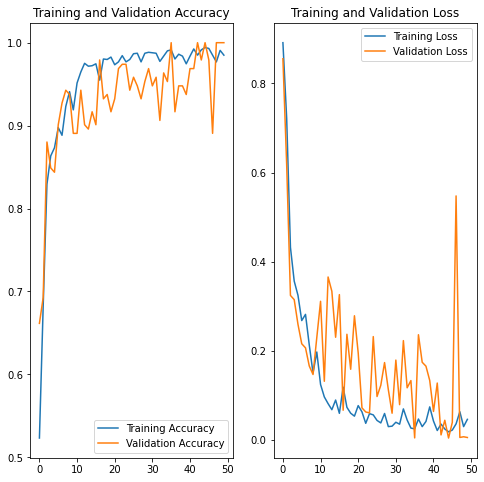

In [39]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.axis("on")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.axis("on")
plt.show()


In [40]:
import numpy as np

first image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 1s 644ms/step
predicted label: Potato___Early_blight


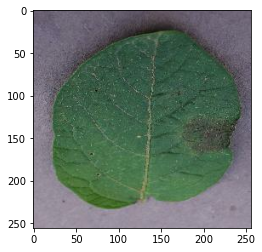

In [41]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


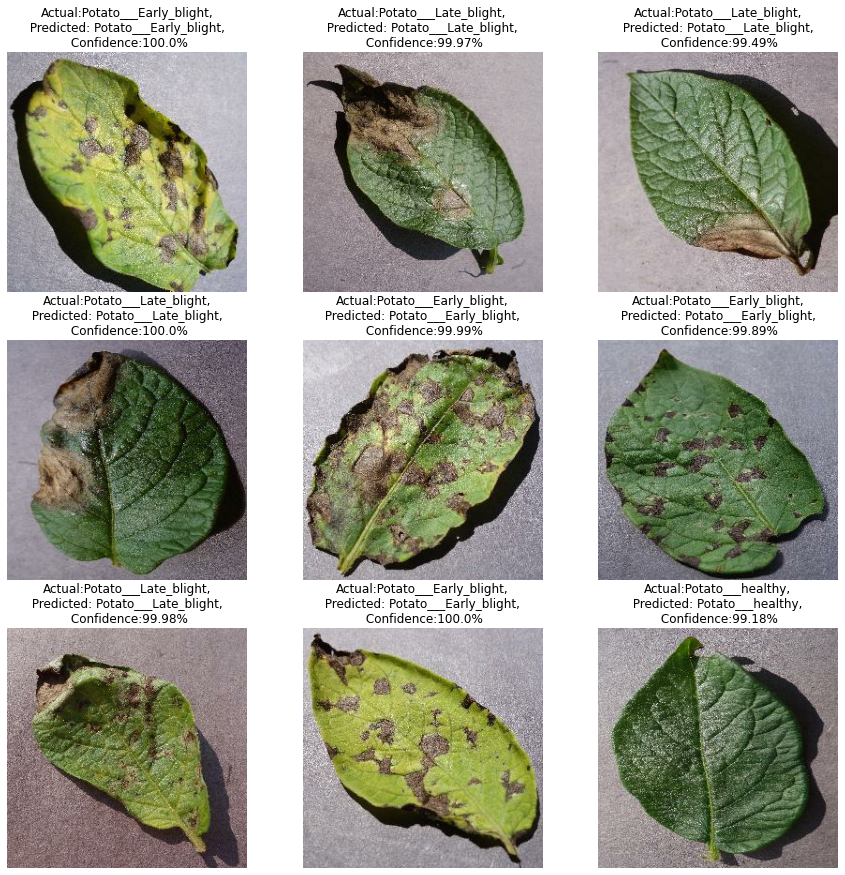

In [43]:
plt.figure(figsize=(15, 15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}, \n Confidence:{confidence}%")
        
        plt.axis("off")
        

In [44]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


# VGG16

In [45]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 


IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
VGG16_MODEL=VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

for layer in VGG16_MODEL.layers[:-2]:
            layer.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
hidden_1 = layers.Dense(4096, activation='relu')
hidden_2 = layers.Dense(1072, activation='relu')
dropout = layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(n_classes, activation='softmax')

model_vgg16 = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  VGG16_MODEL,
  global_average_layer,
  hidden_1,
  hidden_2,
  dropout,
  prediction_layer
])

model_vgg16.build(input_shape = input_shape)

In [47]:
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (32, 512)                0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (32, 4096)                2101248   
                                                                 
 dense_3 (Dense)             (32, 1072)                4391984   
                                                      

In [48]:
model_vgg16.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [49]:
history = model_vgg16.fit(
    train_ds,
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 752s 14s/step - loss: 0.5835 - accuracy: 0.7801 - val_loss: 0.2619 - val_accuracy: 0.8906
Epoch 2/50
54/54 [==============================] - 753s 14s/step - loss: 0.2197 - accuracy: 0.9248 - val_loss: 0.3292 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 4379s 82s/step - loss: 0.2035 - accuracy: 0.9178 - val_loss: 0.0614 - val_accuracy: 0.9792
Epoch 4/50
54/54 [==============================] - 795s 15s/step - loss: 0.1426 - accuracy: 0.9473 - val_loss: 0.0829 - val_accuracy: 0.9740
Epoch 5/50
54/54 [==============================] - 750s 14s/step - loss: 0.1204 - accuracy: 0.9583 - val_loss: 0.2692 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 756s 14s/step - loss: 0.1095 - accuracy: 0.9583 - val_loss: 0.0330 - val_accuracy: 0.9948
Epoch 7/50
54/54 [==============================] - 11885s 224s/step - loss: 0.1029 - accuracy: 0.9647 - val_loss: 0.0257 - val_accuracy: 1.0000
Ep

In [50]:
scores = model_vgg16 .evaluate(test_ds)

8/8 [==============================] - 95s 12s/step - loss: 0.0035 - accuracy: 1.0000


In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

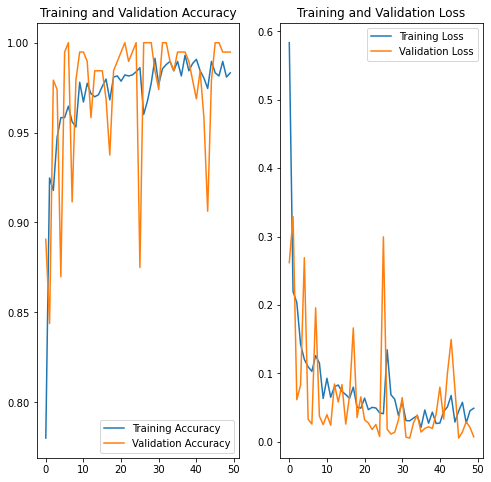

In [52]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 1s 609ms/step
predicted label: Potato___Early_blight


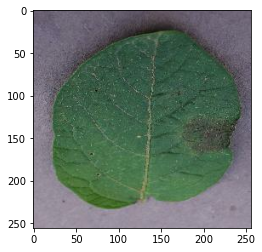

In [53]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [54]:
def predict(model_vgg16, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model_vgg16.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 453ms/step


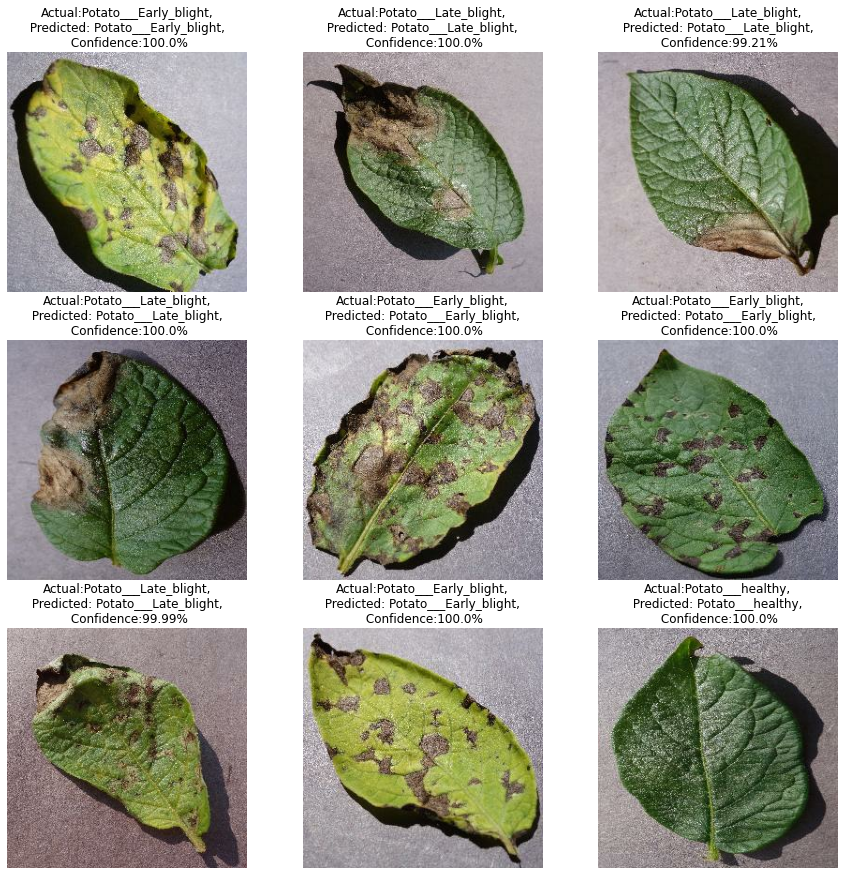

In [55]:
plt.figure(figsize=(15, 15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_vgg16, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}, \n Confidence:{confidence}%")
        
        plt.axis("off")
        

# Inception Net

In [56]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [57]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes = 3 


IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

for layer in base_model.layers:
    layer.trainable = False


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
hidden_1 = layers.Dense(1024, activation='relu')
prediction_layer = tf.keras.layers.Dense(n_classes, activation='softmax')


model_inceptionV3 = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  base_model,
  global_average_layer,
  hidden_1,
  prediction_layer
])

model_inceptionV3.build(input_shape = input_shape)

In [58]:
model_inceptionV3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (32, 2048)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (32, 1024)                2098176   
                                                                 
 dense_6 (Dense)             (32, 3)                   3075      
                                                      

In [59]:
model_inceptionV3.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [60]:
history = model_inceptionV3.fit(
    train_ds,
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 176s 3s/step - loss: 0.7621 - accuracy: 0.7755 - val_loss: 0.2547 - val_accuracy: 0.8854
Epoch 2/50
54/54 [==============================] - 168s 3s/step - loss: 0.2302 - accuracy: 0.9120 - val_loss: 0.2717 - val_accuracy: 0.9010
Epoch 3/50
54/54 [==============================] - 169s 3s/step - loss: 0.2267 - accuracy: 0.9062 - val_loss: 0.2460 - val_accuracy: 0.9062
Epoch 4/50
54/54 [==============================] - 170s 3s/step - loss: 0.1593 - accuracy: 0.9410 - val_loss: 0.3449 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 169s 3s/step - loss: 0.1266 - accuracy: 0.9566 - val_loss: 0.1797 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 169s 3s/step - loss: 0.1676 - accuracy: 0.9381 - val_loss: 0.1910 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 169s 3s/step - loss: 0.1285 - accuracy: 0.9502 - val_loss: 0.1743 - val_accuracy: 0.9531
Epoch 8/50
54

In [61]:
scores = model_inceptionV3 .evaluate(test_ds)

8/8 [==============================] - 22s 3s/step - loss: 0.0356 - accuracy: 0.9883


In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

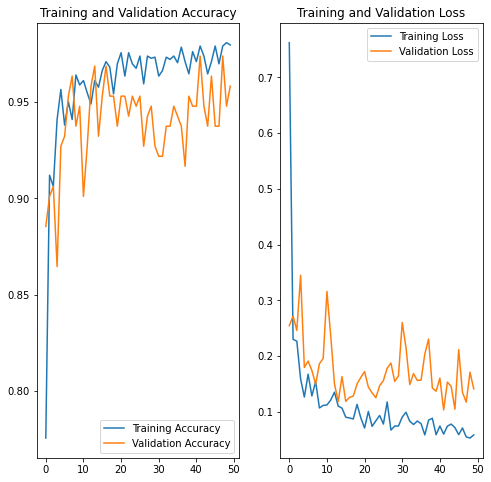

In [63]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 1s 614ms/step
predicted label: Potato___Early_blight


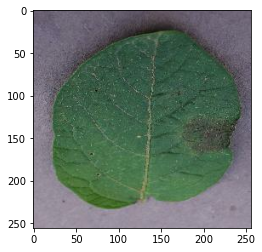

In [64]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [65]:
def predict(model_inceptionV3, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model_inceptionV3.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 110ms/step


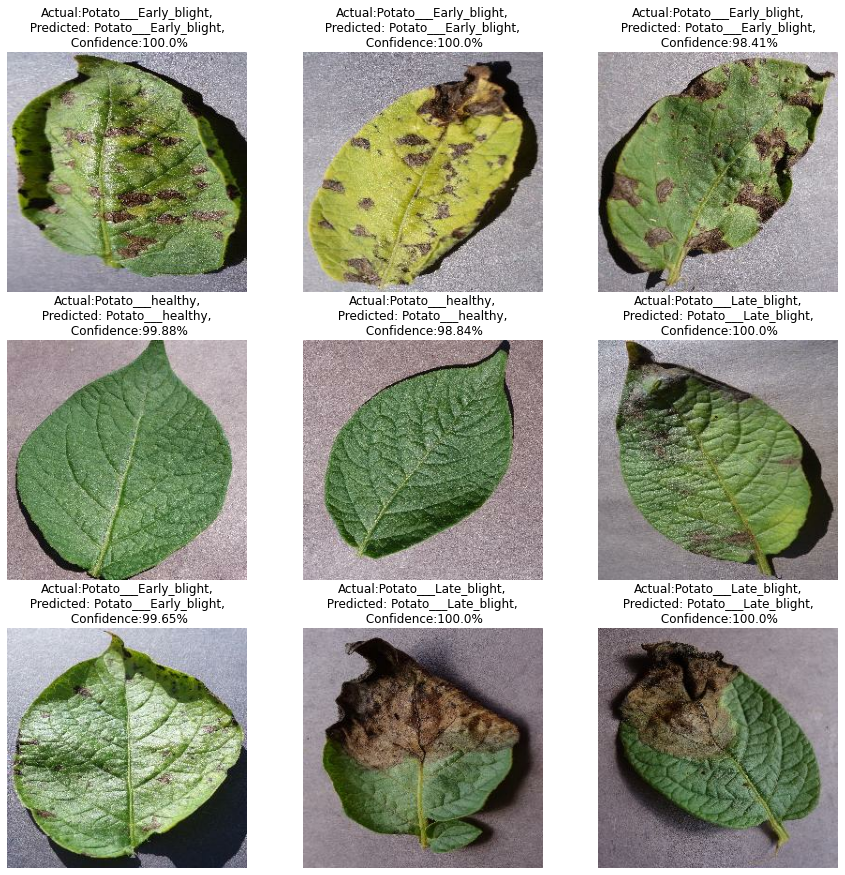

In [66]:
plt.figure(figsize=(15, 15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_inceptionV3, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}, \n Confidence:{confidence}%")
        
        plt.axis("off")
        